#### Introduction

The purpose of this notebook, along with 01_purpose_and_data_setup.ipynb and 02_demo_run_example.ipynb is to provide a tutorial of how you may want to use the `popexposure` package.

Please see 01_purpose_and_data_setup.ipynb and 02_demo_run_example.ipynb before you work through this notebook!

This notebook is going to explore the results returned by `popexposure` from runs in the previous sections of the tutorial. 

In the previous section, we found the number of people affected by one or more California wildfire disasters in 2016, 2017, and 2018, as well as the number of people affected by each unique wildfire disaster, and we broke these same estimates down by ZCTA. Here, we'll plot and explore the results and talk about in which circumstances they might be useful.

#### Outline
1. Output from "total number of people residing within 10km of one or more California wildfire 
disasters in 2016, 2017, and 2018".
2. Output from "total number of people residing within 10 km of each unique California wildfire
disaster in 2016, 2017, and 2018".
3. Output from "total number of people residing within 10km of one or more California wildfire 
disasters in 2016, 2017, and 2018 by 2020 ZCTA", as well as output from "population of all 2020 ZCTAs". 
4. Output from "total number of people residing within 10 km of each unique California wildfire
disaster in 2016, 2017, and 2018 by 2020 ZCTA".


#### 1. Output from "total number of people residing within 10km of one or more California wildfire disasters in 2016, 2017, and 2018".

To use these results, we'll first read in and plot the original wildfire disaster dataset, and then read in the results and calculate the total number of people affected by any wildfire disaster.

We'll start by loading libraries and reading in necessary data. 

In [18]:
import geopandas as gpd 
import pandas as pd
import pathlib
import glob

# some plotting packages for the plots we'll make
import contextily as ctx
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Circle
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

We'll read in the ZCTA data, since the last three `popexposure` runs involved ZCTAs, and we'll plot the wildfire disaster data over the California ZCTAs so we can get an idea of what the dataset looks like. 

In [19]:
# Define the base path and data directory
base_path = pathlib.Path.cwd()
data_dir = base_path / "demo_data"

# Read the raw ZCTA data
zctas = gpd.read_file(data_dir / "01_raw_data" / "tl_2020_us_zcta520" / "tl_2020_us_zcta520.shp")

# Filter ZCTAs for California ZIP codes (90000 to 96100)
zctas_ca = zctas[zctas['GEOID20'].str[:3].astype(int).between(900, 961)]

# Transform to best CRS for plotting CA
teale_albers_crs = "EPSG:3310"
zctas_ca = zctas_ca.to_crs(teale_albers_crs)

In [20]:
# Read in raw wildfire dataset
fires = gpd.read_file(data_dir / "01_raw_data"/ "dataverse_files" / "wfbz_disasters_2000-2025.geojson")

# Filter to wildfires in California that occurred between 2016 and 2018 (inclusive)
fires_ca = fires[(fires['wildfire_states'].str.contains('CA'))]

# Transform to best CRS for plotting California
fires_ca = fires_ca.to_crs(teale_albers_crs)

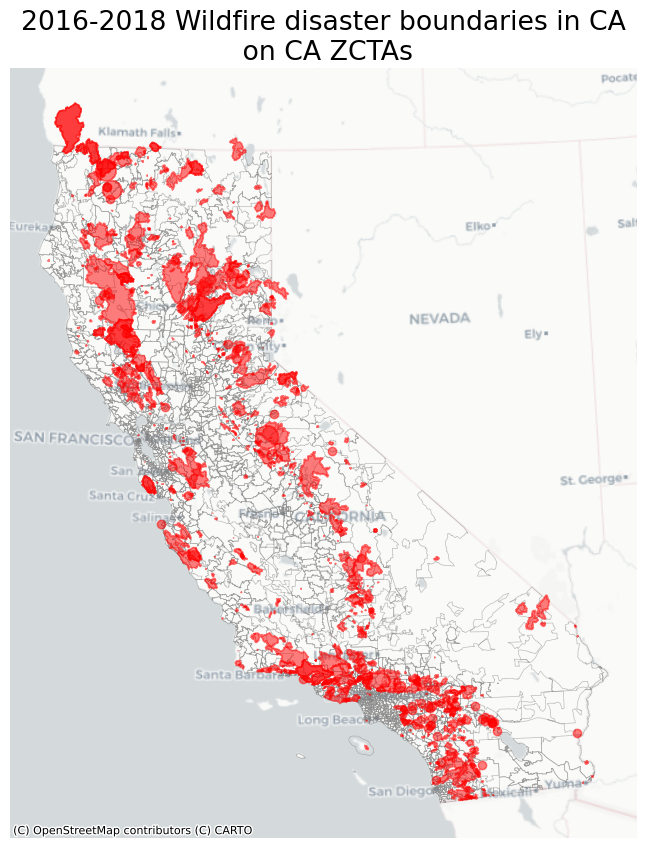

In [21]:
# Plot the fires overlayed onto ZCTA boundaries
# Set text size to readable
plt.rcParams.update({'font.size': 16})

# Plot the ZCTA boundaries first
fig, ax = plt.subplots(figsize=(10, 10))
zctas_ca.boundary.plot(ax=ax, linewidth=0.5, edgecolor='grey', alpha = 0.5, 
                       zorder=1)

# Overlay the fire geometries with red fill
fires_ca.plot(ax=ax, color='red', alpha=0.5, edgecolor='red', zorder=2)

# Set plot title and labels
ax.set_title('2016-2018 Wildfire disaster boundaries in CA\n on CA ZCTAs')
ax.set_axis_off()

# Add a basemap using contextily - this slows things down a lot if it's high
# resolution so we'll let it be blurry for now
ctx.add_basemap(ax, crs=zctas_ca.crs.to_string(), 
                source=ctx.providers.CartoDB.Positron)


# Saving for use in the paper describing the Pop_Exp package
output_path = data_dir / "03_results" / "wildfire_zcta_plot_2018.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')

Again, in the previous section of this tutorial, we calculated five things. We'll start by exploring the results of the the first calculation: in the first run of `est_exposed_pop`, we calculated total people residing within 10 km of one or more wildfire disasters in the US the years 2016, 2017, and 2018. Let's read in those results.

If a user ran `est_exposed_pop` this way, they might be interested in the total number of people affected by wildfire disasters in each year, which is exactly what the function returns already without us having to do any additional work. 

In [22]:
# Read output of find_num_people_affected 
tot_af_any_wf = pd.read_parquet(data_dir / "03_results" / "num_people_affected_by_wildfire.parquet")
tot_af_any_wf.head()

,ID_hazard,exposed_10,year
0,merged_geoms,1618983,2016
0,merged_geoms,5194948,2017
0,merged_geoms,1812166,2018


Note the column names, types, etc., and how there are no longer hazard IDs, since we counted everyone within the unary union of all hazards in the data.

#### 2. Output from "total number of people residing within 10 km of each unique California wildfire disaster in 2016, 2017, and 2018".

Moving on to the second run. 

In this run, we calculated the total number of people residing within 10km of each unique disaster in each year, by running `est_exposed_pop` with the parameter `hazard_specific = True`. Someone might have run `est_exposed_pop` this way if they wanted to identify the most 5 most impactful wildfire disasters in each year, where the boundaries were closest to the largest residential population. To explore the results of this run, we'll find those worst 5 disasters and plot them. 

In [23]:
# Read in output from find_num_people_affected
tot_unique_wf = pd.read_parquet(data_dir / "03_results" / "num_aff_by_unique_wildfire.parquet")
tot_unique_wf.head()

,ID_hazard,exposed_10,year
0,7.0,14037,2016
1,14.0,209,2016
2,41.0,17,2016
3,58.0,11742,2016
4,94.0,460858,2016


Note the column names, types again. 

In [24]:
# Want to group this data by year and find the 5 largest wildfires in each year
# Sort the DataFrame by 'year' and 'num_people_affected' 
sorted_wfs = tot_unique_wf.sort_values(by=['year', 'exposed_10'], ascending=[True, False])

# Group by 'year' and get the top 5
high_impact_wfs = sorted_wfs.groupby('year').head(5).reset_index(drop=True)
high_impact_wfs

,ID_hazard,exposed_10,year
0,440.0,499536,2016
1,94.0,460858,2016
2,1545.0,460858,2016
3,315.0,193200,2016
4,1645.0,191973,2016
5,316.0,1106871,2017
6,1681.0,1106871,2017
7,360.0,990817,2017
8,2000.0,792107,2017
9,246.0,702860,2017


Now we want to plot these. Because `est_exposed_pop` doesn't preserve the geometry column, we need to rejoin that information to the results. 

In [25]:
# Prepare to join by correcting col names
fires_ca = fires_ca.rename(columns={'wildfire_id': 'ID_hazard'})
fires_ca = fires_ca[['ID_hazard', 'geometry']].copy()
# And join to get the geographic locations
high_impact_wfs = high_impact_wfs.merge(fires_ca, on='ID_hazard', how='left')


Now let's plot these most impactful disasters on top of the Califonia ZCTAs, so we can see where they are. Let's add some circles proportional to the number of people that were residing within 10 km of each wildfire disaster. 

We're going to need to work for this plot a little bit. 

In [26]:
# Want to make a dataframe with the coordinates of each disaster to plot on top of ZCTAs
# Get the coordinates in the right CRS
high_impact_wfs = high_impact_wfs.set_geometry('geometry')
high_impact_wfs = high_impact_wfs.to_crs(teale_albers_crs) # reproj to teale
high_impact_wfs['latitude'] = high_impact_wfs['geometry'].centroid.y
high_impact_wfs['longitude'] = high_impact_wfs['geometry'].centroid.x

# Create df of those coordinates
coords = gpd.GeoDataFrame(high_impact_wfs, geometry=gpd.points_from_xy(high_impact_wfs.longitude, high_impact_wfs.latitude))
coords['radius'] = high_impact_wfs['exposed_10'] / 50
coords['year'] = coords['year'].astype('category')

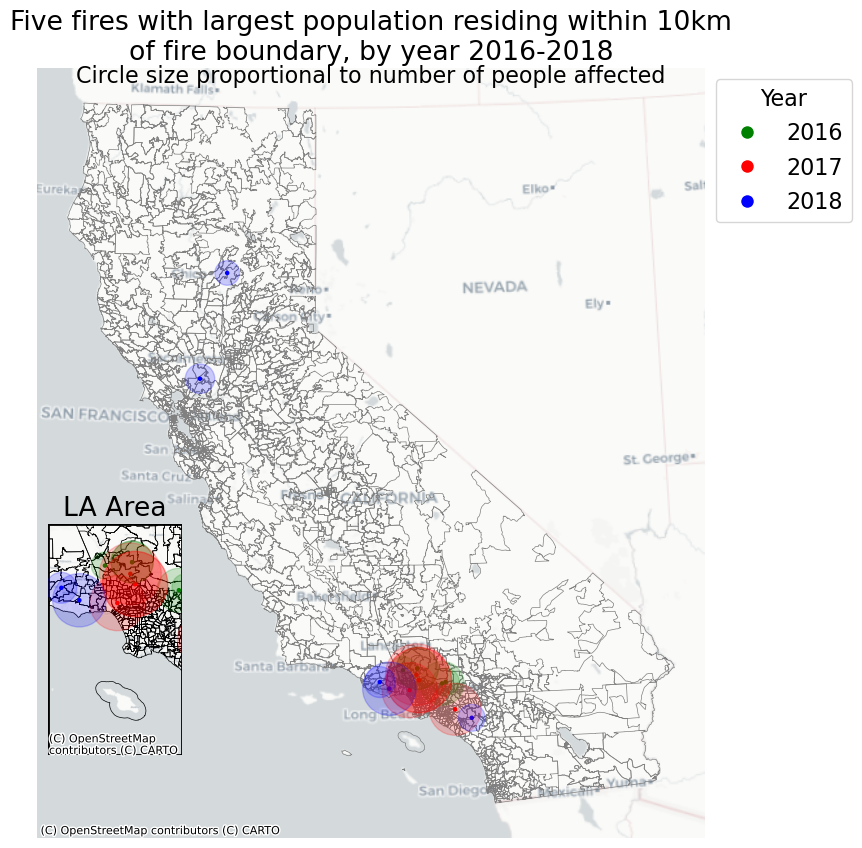

In [27]:
# Make a df of LA ZCTAs to use for the inset map
la_zctas = zctas_ca[zctas_ca['GEOID20'].astype(int).between(90001, 91699)]

# Make plot
# Set text size
plt.rcParams.update({'font.size': 16})

# Set up to plot by specifying the colors we want to use for each year 
color_dict = {2016: 'green', 2017: 'red', 2018: 'blue'}

# And plot. 
# Plot the ZCTA boundaries first
fig, ax = plt.subplots(figsize=(10, 10))
zctas_ca.boundary.plot(ax=ax, linewidth=0.5, edgecolor='grey', zorder=1)

# Plot the wildfire coordinates and a circle proportional to the number of 
# people affected, colored by year
coords.plot(ax=ax, color=coords['year'].map(color_dict), markersize=5, zorder=2)
plt.scatter(coords.geometry.x, coords.geometry.y, s=coords['radius']*0.1, 
            color=coords['year'].map(color_dict), alpha=0.2, zorder=2)

# Set plot title and labels
ax.set_title('Five fires with largest population residing within 10km\n' 
             'of fire boundary, by year 2016-2018')
ax.text(0.5, 0.99, 'Circle size proportional to number of people affected', 
     horizontalalignment='center', verticalalignment='center', 
     transform=ax.transAxes)
ax.set_axis_off()

# Add a legend
legend_elements = [Line2D([0], [0], 
    marker='o', color='w', label=str(year), markerfacecolor=color, 
    markersize=10) for year, color in color_dict.items()]
ax.legend(handles=legend_elements, title='Year', loc='upper left', 
    bbox_to_anchor=(1, 1))

# Create an inset map for LA area with adjusted position
ax_inset = inset_axes(ax, width="30%", height="30%", loc='lower left', 
    bbox_to_anchor=(-0.10, 0.05, 1, 1), bbox_transform=ax.transAxes, 
    borderpad=2)
zctas_ca.boundary.plot(ax=ax_inset, linewidth=0.5, edgecolor='black')

coords.plot(ax=ax_inset, color=coords['year'].map(color_dict), markersize=5, 
    zorder=2)
plt.scatter(coords.geometry.x, coords.geometry.y, s=coords['radius']*0.1, 
    color=coords['year'].map(color_dict), alpha=0.2, zorder=2)

# Set the extent of the inset map to the bounds of the LA ZCTAs
xmin, ymin, xmax, ymax = la_zctas.total_bounds
ax_inset.set_xlim(xmin, xmax)
ax_inset.set_ylim(ymin, ymax)

ax_inset.set_title('LA Area')
ax_inset.set_axis_off()

# Add a basemap
ctx.add_basemap(ax, crs=zctas_ca.crs.to_string(), 
                source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax_inset, crs=zctas_ca.crs.to_string(), 
                source=ctx.providers.CartoDB.Positron)

# Add a box around the inset map
rect = plt.Rectangle((0, 0), 1, 1, transform=ax_inset.transAxes, 
                     color='none', ec='black', lw=2)
ax_inset.add_patch(rect)

Ok - that's what we wanted from the second run.

#### 3. Output from "total number of people residing within 10km of one or more California wildfire disasters in 2016, 2017, and 2018 by 2020 ZCTA", as well as output from "population of all 2020 ZCTAs". 

Now, let's visualize the results of the third demonstration we did, where we ran `est_exposed_pop` with additional administrative units, ZCTAs. In this case, we found the number of people who lived within 10 km of any wildfire disaster by year and by ZCTA, and the number of people who lived within 10 km of each wildfire disaster by ZCTA. 

Why would someone want the number of people who lived within 10 km of any wildfire disaster by year and by ZCTA? A researcher might want to assess wildfire disaster exposure by ZCTA. They might want to know what proportion of people in each ZCTA lived within 10 km of any disaster boundary and were therefore exposed to fire, and then consider a ZCTA exposed if enough of its population was exposed. If we were doing that exposure assessment, we'd probably want to plot the proportion of people exposed to disasters by ZCTA. 

Let's use our results to do that. To accomplish that, we also need to use the denominator data that we produced at the end of the last section, where we found the ZCTA-level population. 

Let's start by reading in that denominator data, and plotting the number of people who live in each ZCTA.

In [28]:
# Read results showing the number of people residing in each ZCTA
num_residing_by_zcta = pd.read_parquet(data_dir / "03_results" / "num_people_residing_by_zcta.parquet")

# CA only based on ZCTAs
num_residing_ca = num_residing_by_zcta[pd.to_numeric(num_residing_by_zcta['ID_admin_unit']).between(90000, 96100)].copy()

# select cols ID spatial unit and num_people_affected
num_residing_ca = num_residing_ca[["ID_admin_unit",  "population"]]
num_residing_ca.head()

,ID_admin_unit,population
0,95641,2279
1,95680,162
2,95919,1560
3,95920,289
4,95930,209


In [29]:
# Clean zctas for plotting
zctas_ca.rename(columns={"ZCTA5CE20": "ID_admin_unit"}, inplace=True)
zctas_ca = zctas_ca[["ID_admin_unit", "geometry"]]

# Merge population data to zctas_ca geometry for plotting
zctas_ca = zctas_ca.merge(num_residing_ca, on="ID_admin_unit", how="left")

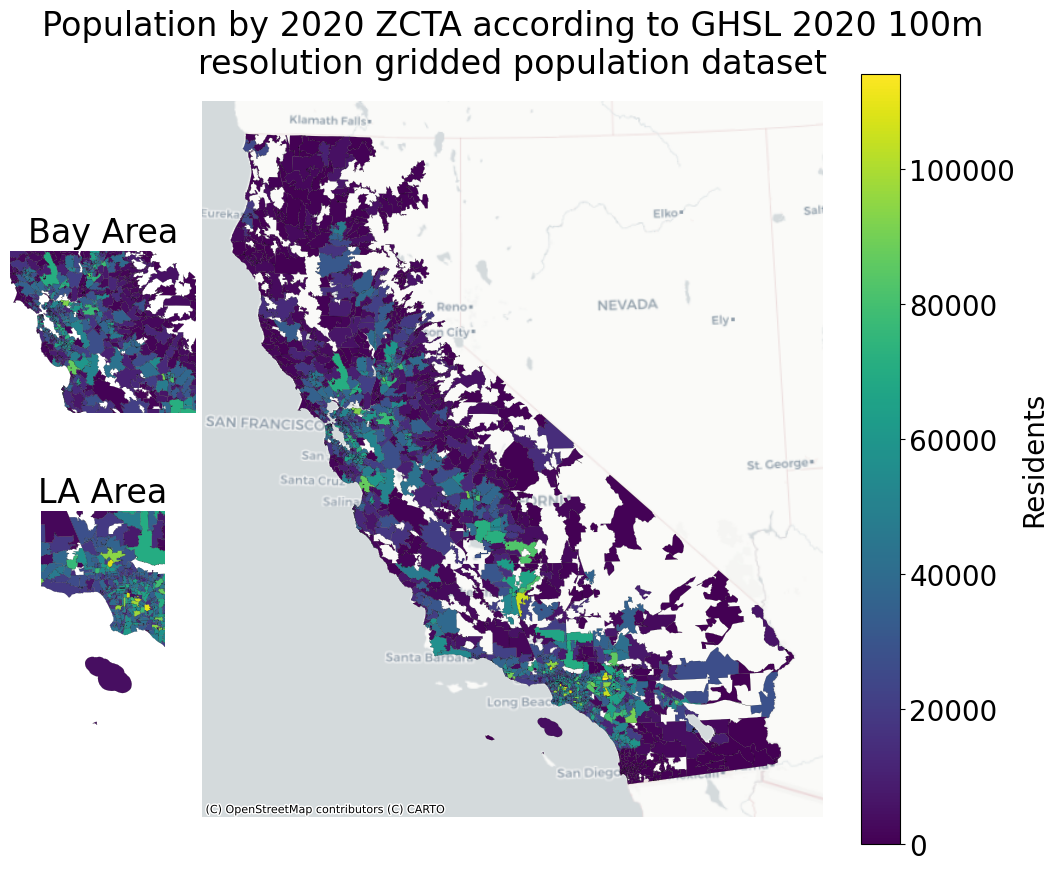

In [31]:
# Update font size
plt.rcParams.update({'font.size': 20})

# Define an sf zcta dataframe to help make a map inset
sf_zctas = zctas_ca[zctas_ca['ID_admin_unit'].astype(int).between(94000, 95399)]

# Create main plot without legend
fig, ax = plt.subplots(figsize=(10, 10))
zctas_ca.plot(column='population', ax=ax, cmap='viridis', 
              linewidth=0.1, edgecolor='black', legend=True, 
              legend_kwds={'label': "Residents"})

# Set plot title and labels
ax.set_title('Population by 2020 ZCTA according to GHSL 2020 100m\n' 
             'resolution gridded population dataset', pad=20)
ax.set_axis_off()

# Create an inset map for LA area
ax_inset_la = inset_axes(ax, width="30%", height="30%", loc='lower left', 
                         bbox_to_anchor=(-0.4, 0.05, 1, 1), 
                         bbox_transform=ax.transAxes, borderpad=2)
zctas_ca.plot(column='population', ax=ax_inset_la, cmap='viridis', 
              linewidth=0.1, edgecolor='black')

# Set the extent of the inset map to the bounds of the LA ZCTAs
xmin, ymin, xmax, ymax = la_zctas.total_bounds
ax_inset_la.set_xlim(xmin, xmax)
ax_inset_la.set_ylim(ymin, ymax)
ax_inset_la.set_title('LA Area')
ax_inset_la.set_axis_off()

# Create an inset map for SF area with adjusted position
ax_inset_sf = inset_axes(ax, width="30%", height="30%", loc='lower left', 
                         bbox_to_anchor=(-0.4, 0.45, 1, 1), 
                         bbox_transform=ax.transAxes, borderpad=2)
zctas_ca.plot(column='population', ax=ax_inset_sf, cmap='viridis', 
              linewidth=0.1, edgecolor='black')

# Set the extent of the inset map to the bounds of the SF ZCTAs
xmin, ymin, xmax, ymax = sf_zctas.total_bounds
ax_inset_sf.set_xlim(xmin, xmax)
ax_inset_sf.set_ylim(ymin, ymax)
ax_inset_sf.set_title('Bay Area')
ax_inset_sf.set_axis_off()

ctx.add_basemap(ax, crs=zctas_ca.crs.to_string(), 
                source=ctx.providers.CartoDB.Positron)

# Save fig for use in pop_exp package paper
output_path = data_dir / "03_results" / "pop_by_zcta_plot.png"
plt.savefig(output_path, format='png', bbox_inches='tight', dpi=300)  

Those are our denominators. Now let's get the number of people affected by one or more wildfires by ZCTA. 

In [32]:
# Read output of find_num_people_affected_by_geo
wf_by_zcta = pd.read_parquet(data_dir / "03_results" / 
                             "num_people_affected_by_wildfire_by_zcta.parquet")
wf_by_zcta.head()

,ID_hazard,ID_admin_unit,exposed_10,year
0,merged_geoms,91352,1349,2016
1,merged_geoms,91731,1710,2016
2,merged_geoms,91739,1632,2016
3,merged_geoms,91791,13943,2016
4,merged_geoms,92322,1484,2016


In [33]:
zctas_ca.head()

,ID_admin_unit,geometry,population
0,95641,"POLYGON ((-147997.721 13211.636, -147973.253 1...",2279.0
1,95680,"POLYGON ((-140058.73 25739.845, -140057.705 25...",162.0
2,95919,"POLYGON ((-114402.753 158740.425, -114394.887 ...",1560.0
3,95920,"POLYGON ((-172890.473 158186.754, -172877.207 ...",289.0
4,95930,"POLYGON ((-104158.672 171035.475, -104137.787 ...",209.0


In [34]:
# someone actually doing this might want to plot all years, but let's just 
# select 2018 and plot that
wf_by_zcta_2018 = wf_by_zcta[wf_by_zcta['year'] == 2018].copy()
# drop the year col
wf_by_zcta_2018.drop(columns='year', inplace=True)
wf_by_zcta_2018.head()

,ID_hazard,ID_admin_unit,exposed_10
0,merged_geoms,95973,24474
1,merged_geoms,96051,1202
2,merged_geoms,91301,26090
3,merged_geoms,96003,40926
4,merged_geoms,96031,61


In [35]:
# sum num aff in CA
tot_num_aff_ca = wf_by_zcta_2018['exposed_10'].sum()
tot_num_aff_ca

np.int64(1806426)

In [37]:
# merge to zctas_ca geometry for plotting
zctas_ca_wf = zctas_ca.merge(wf_by_zcta_2018, on="ID_admin_unit", how="left")
zctas_ca_wf.head()

,ID_admin_unit,geometry,population,ID_hazard,exposed_10
0,95641,"POLYGON ((-147997.721 13211.636, -147973.253 1...",2279.0,NaN,NaN
1,95680,"POLYGON ((-140058.73 25739.845, -140057.705 25...",162.0,NaN,NaN
2,95919,"POLYGON ((-114402.753 158740.425, -114394.887 ...",1560.0,NaN,NaN
3,95920,"POLYGON ((-172890.473 158186.754, -172877.207 ...",289.0,NaN,NaN
4,95930,"POLYGON ((-104158.672 171035.475, -104137.787 ...",209.0,NaN,NaN


In [38]:
# fill in NAs in num people affected with 0
zctas_ca_wf['exposed_10'] = zctas_ca_wf['exposed_10'].fillna(0)
zctas_ca_wf.head()


,ID_admin_unit,geometry,population,ID_hazard,exposed_10
0,95641,"POLYGON ((-147997.721 13211.636, -147973.253 1...",2279.0,NaN,0.0
1,95680,"POLYGON ((-140058.73 25739.845, -140057.705 25...",162.0,NaN,0.0
2,95919,"POLYGON ((-114402.753 158740.425, -114394.887 ...",1560.0,NaN,0.0
3,95920,"POLYGON ((-172890.473 158186.754, -172877.207 ...",289.0,NaN,0.0
4,95930,"POLYGON ((-104158.672 171035.475, -104137.787 ...",209.0,NaN,0.0


In [39]:
# find the proportion of people affected by ZCTA
zctas_ca_wf['prop_aff'] = zctas_ca_wf['exposed_10'] / zctas_ca_wf['population']

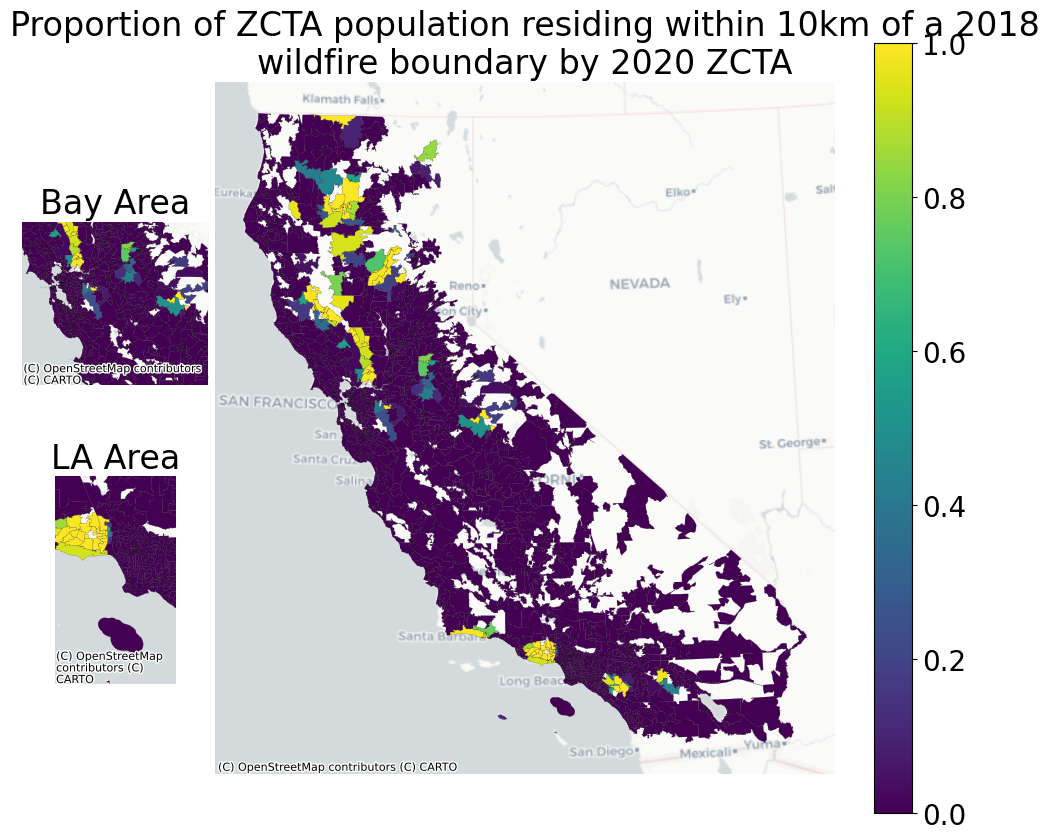

In [40]:
# Plot. 
fig, ax = plt.subplots(figsize=(10, 10))
zctas_ca_wf.plot(column='prop_aff', ax=ax, legend=True, cmap='viridis', 
                 linewidth=0.1, edgecolor='black')

# Set plot title and labels
ax.set_title('Proportion of ZCTA population residing within 10km of a 2018\n'
             'wildfire boundary by 2020 ZCTA')
ax.set_axis_off()

# Create an inset map for LA area with adjusted position
ax_inset_la = inset_axes(ax, width="30%", height="30%", loc='lower left', 
    bbox_to_anchor=(-0.4, 0.05, 1, 1), bbox_transform=ax.transAxes, borderpad=2)
zctas_ca_wf.plot(column='prop_aff', ax=ax_inset_la, cmap='viridis', 
                 linewidth=0.1, edgecolor='black', legend=False)

# Set the extent of the inset map to the bounds of the LA ZCTAs
xmin, ymin, xmax, ymax = la_zctas.total_bounds
ax_inset_la.set_xlim(xmin, xmax)
ax_inset_la.set_ylim(ymin, ymax)

ax_inset_la.set_title('LA Area')
ax_inset_la.set_axis_off()

# Create an inset map for SF area with adjusted position
ax_inset_sf = inset_axes(ax, width="30%", height="30%", loc='lower left', 
    bbox_to_anchor=(-0.4, 0.45, 1, 1), bbox_transform=ax.transAxes, borderpad=2)
zctas_ca_wf.plot(column='prop_aff', ax=ax_inset_sf, cmap='viridis', 
                 linewidth=0.1, edgecolor='black', legend=False)

# Set the extent of the inset map to the bounds of the SF ZCTAs
xmin, ymin, xmax, ymax = sf_zctas.total_bounds
ax_inset_sf.set_xlim(xmin, xmax)
ax_inset_sf.set_ylim(ymin, ymax)

ax_inset_sf.set_title('Bay Area')
ax_inset_sf.set_axis_off()

ctx.add_basemap(ax, crs=zctas_ca.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax_inset_la, crs=zctas_ca.crs.to_string(), 
                source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax_inset_sf, crs=zctas_ca.crs.to_string(), 
                source=ctx.providers.CartoDB.Positron)


# Save output path
output_path = data_dir / "03_results" / "prop_pop_by_wf_by_zcta_plot.png"
plt.savefig(output_path, format='png', bbox_inches='tight', dpi=300)  

Ok, there it is.

One final thing about this output - this output shows us the proprtion of the ZCTA population residing within 10km of a wildfire disaster boundary by ZCTA. 

If instead of the total population, we wanted to find the total number of people making >100,000$ in household income living within 10km of a wildfire disaster boundary by ZCTA, or the total number children under the age of 5 residing within 10km of a wildfire disaster boundary by ZCTA, we could use census data together with this function output to do this. If we assume that the population of interest (ex. children under 5) is uniformly distributed throughout the residential population, we can take the function output describing the proportion of the population residing within 10km of the fire boundaries and multiply this by the under 5 population to estimate the number of children exposed. This is improves upon the strategy of using census data and hazard boundaries to find the exposed populuation, which assumes that the population is uniformly distributed across space. We could do this for any census-described population. 

#### 4. Output from "total number of people residing within 10 km of each unique California wildfire disaster in 2016, 2017, and 2018 by 2020 ZCTA".

Finally, let's look at the results from finding the number of people affected by each unique wildfire disaster in each ZCTA, the fourth quantity we calculated in the previous section of the tutorial. There are many reasons why someone might want to calculate this type of exposure - maybe they want to look at multiple exposures. A researcher might be interested in this option if they wanted to know about multiple exposures in the same ZCTA or a group of ZCTAs, maybe for an interrupted time series analysis or something similar. If that was the goal, they might want to look at exposure over time in a specific ZCTA. They also might want to know which ZCTAs were affected by a certain disaster.
 
First, let's filter the results to look at ZCTA 90263, downtown Malibu.

In [41]:
# need to read in results 
unique_wf_by_zcta = pd.read_parquet(data_dir / "03_results" / "num_people_affected_by_wildfire_zcta_unique.parquet")
unique_wf_by_zcta.head()

,ID_hazard,ID_admin_unit,exposed_10,year
0,14.0,93451,0,2016
1,14.0,93210,208,2016
2,41.0,93546,5,2016
3,41.0,93529,3,2016
4,58.0,95694,9434,2016


In [43]:
# filter to zcta 90263
unique_wf_by_zcta_90263 = unique_wf_by_zcta[unique_wf_by_zcta['ID_admin_unit'] == '90263']
print(unique_wf_by_zcta_90263)

     ID_hazard ID_admin_unit  exposed_10  year
104      457.0         90263        1578  2018


We can see that the Woolsey fire boundary was within 10km of 1578 people living in this ZCTA. The fire burned some structures and homes in Malibu, but did not burn through the whole downtown, so some of these people might have been living in the fire boundary - we'd need to map the raster and fire boundary data to tell. 

Let's also look at all the ZCTAs near the Woolsey Fire boundary.

In [ ]:

unique_wf_by_zcta_woolsey = unique_wf_by_zcta[unique_wf_by_zcta['ID_hazard'] == '2018-11-08_WOOLSEY_CA_VENTURA_5169']
print(unique_wf_by_zcta_woolsey)

     ID_hazard ID_admin_unit  exposed_10  year
93       457.0         91301       26090  2018
94       457.0         91311       37829  2018
95       457.0         91320       46624  2018
96       457.0         91302       26711  2018
97       457.0         91360       44600  2018
98       457.0         91361       21325  2018
99       457.0         90290        6559  2018
100      457.0         93065       76320  2018
101      457.0         93012        9205  2018
102      457.0         90272          23  2018
103      457.0         93042           8  2018
104      457.0         90263        1578  2018
105      457.0         91304       51858  2018
106      457.0         90265       17578  2018
107      457.0         91356        4490  2018
108      457.0         91362       38023  2018
109      457.0         91364       26621  2018
110      457.0         91303       27399  2018
111      457.0         91367       40892  2018
112      457.0         91306       46600  2018
113      457.

How many people lived within 10 km of the Woolsey Fire boundary?

In [46]:
# sum values in num_people_affected in unique_wf_by_zcta_cf
sum_num_people_affected = unique_wf_by_zcta_woolsey['exposed_10'].sum()
print(sum_num_people_affected)

741020


Let's also look at the Camp Fire.

In [ ]:
unique_wf_by_zcta_cf = unique_wf_by_zcta[unique_wf_by_zcta['ID_hazard'] == '2018-11-08_CAMP_CA_BUTTE_5168']
print(unique_wf_by_zcta_cf)

How many ZCTAs were near the Camp Fire?

In [ ]:
# sum values in num_people_affected in unique_wf_by_zcta_cf
sum_num_people_affected = unique_wf_by_zcta_cf['exposed_10'].sum()
print(sum_num_people_affected)

Looks like there were people in 15 different ZCTAs who were living within 10km of the fire boundary or closer - in this case we know this fire burned completely through Paradise so a lot of these people were actually living inside the fire boundary rather than just close to it. 

We already used the output from the fifth function to calculate the proportion of the ZCTA populations affected by wildfire disasters, so that's the end. 

We hope you find these functions useful for population-level environmental exposure assignment. 